In [1]:
import numpy as np
import preprocess_toolset as ppt
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy.ndimage import measurements
import cv2

In [2]:
# Add in the path to the FITS images
path_to_images = "../testFRI" # or use something like this for a absolute path "/home/17522021/testFRI"

In [3]:
onlyfits = [f for f in listdir(path_to_images) if isfile(join(path_to_images, f)) and ".fits" in f]

List of files:

In [4]:
onlyfits

['J170115.59+240608.4.fits',
 'J165448.44+261841.3.fits',
 'J212005.00075350.1.fits',
 'J165425.53+414121.2.fits',
 'J164845.08+254119.5.fits',
 'J165304.98+400702.5.fits',
 'J170543.99+583001.2.fits',
 'J165744.77+215611.1.fits',
 'J163043.14+163910.8.fits',
 'J170011.22+323514.7.fits',
 'J164548.45+393227.4.fits',
 'J214239.29080423.8.fits',
 'J173223.73+552452.8.fits',
 'J165500.19+390847.9.fits',
 'J164053.90+324728.4.fits',
 'J171243.95+620245.0.fits',
 'J171137.98+580330.2.fits',
 'J171223.15+640157.1.fits',
 'J170602.20+201757.8.fits',
 'J223143.19082431.7.fits',
 'J234702.42010300.9.fits']

In [5]:
raw_fits = []
for i in onlyfits:
    raw_fits.append(ppt.read_fits(path_to_images+"/"+i))

I've made some helper functions to better visually inspect the images.

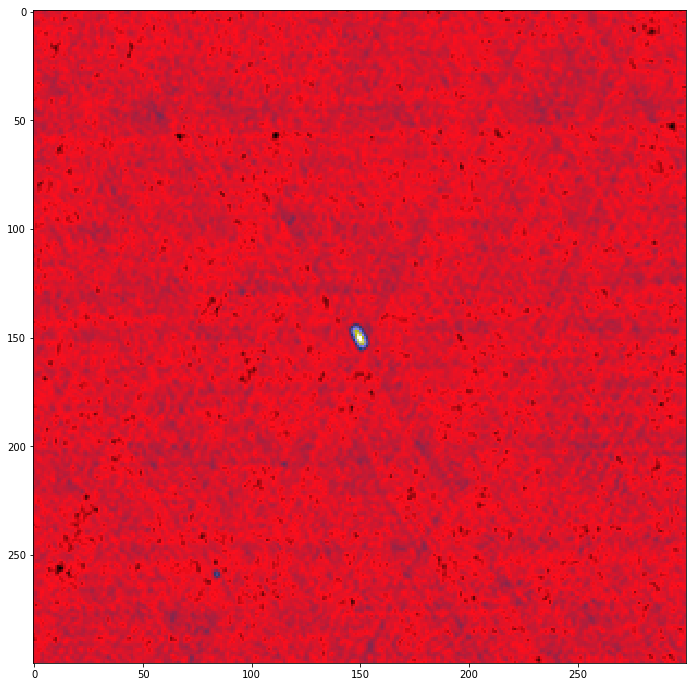

In [6]:
ppt.plot_larger(raw_fits[0])

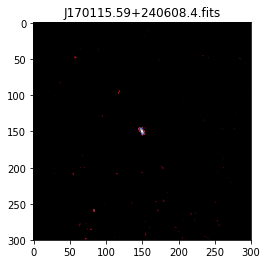

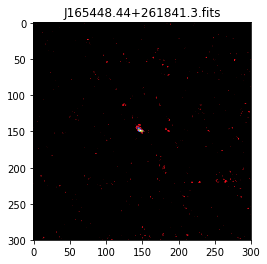

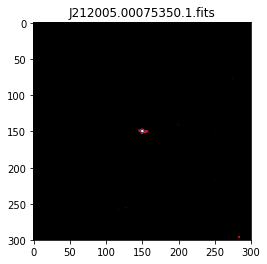

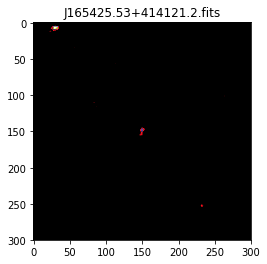

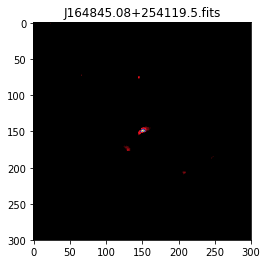

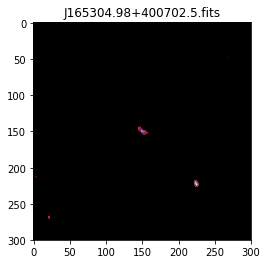

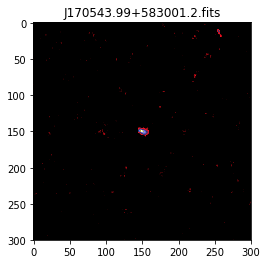

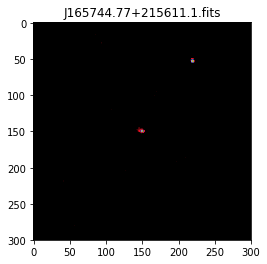

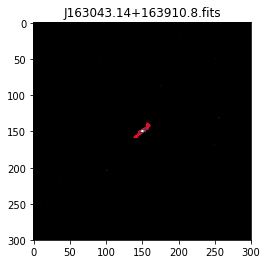

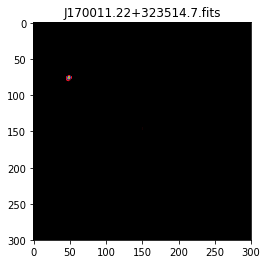

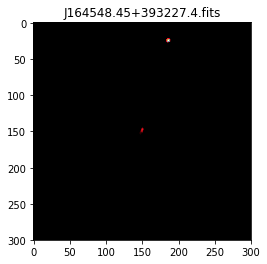

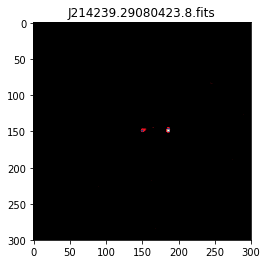

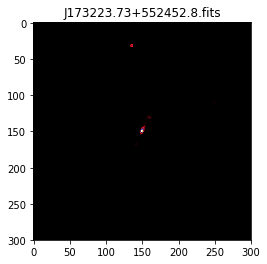

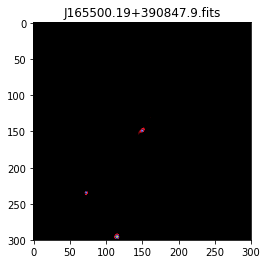

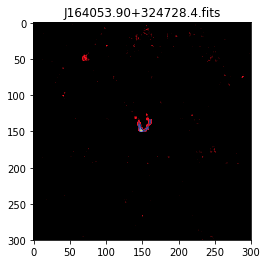

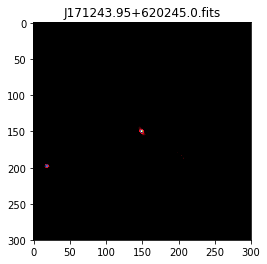

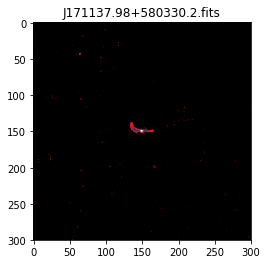

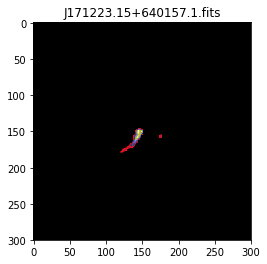

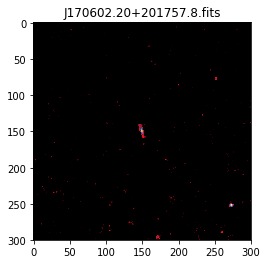

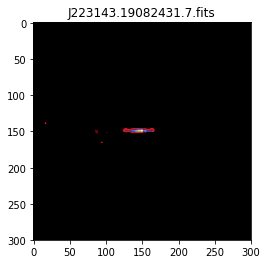

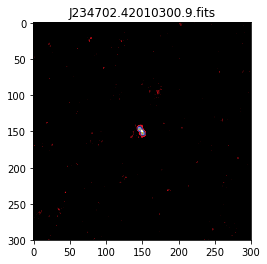

In [53]:
# If you want to visually inspect everything quickly
for i in range(len(raw_fits)):
    plt.set_cmap('gist_stern')
    plt.title(onlyfits[i])
    # Change vmin to fit your needs, currently thresholds everything below 2 standard deviations above the mean
    plt.imshow(raw_fits[i],vmin=np.mean(raw_fits[i])+np.std(raw_fits[i])*2)
    plt.show()

The method below will preprocess the image and return the distance of the brightest hotspot from the center of the image and the number of lobes that remain after this step of preprocessing. It can help for visual inspection of the images and might save some time on visual inspection.

The preprocessing might take a while, Singular Value Decomposition (SVD) has a time complexity of $O(n^3)$ (given a square matrix of size n). Alternatively, you can take out the SVD preprocessing and stick to only sigma clipping and keep the largest lobe (or the n largest lobes if they are relatively equal in size).

How the pipeline works, is it reconstructs the original image (top left) from its Singular Value Decomposition, using only the first 3 singular values of the $\Sigma$ matrix (bottom left). We then binarize this image (centre bottom). Using this in conjunction with a binary threshold of the sigma clipped original image (centre top), that has each disjoint lobe uniquely labelled (top right), we get a final threshold of the image (bottom right). 

[Note, I did not do sigma clipping, since I only clipped values lower than 2 standard deviations above the mean. This is only a threshold.]

<img src="pipelines.png">

In [31]:
dist = []
num_lobes = []
svd_preproc = []

for i in range(len(raw_fits)):
    original = raw_fits[i]
    
    threshed = ppt.preprocess_reverse(original, original.std()*2)
    
    lw, num = measurements.label(threshed)
    arr, larr = np.unique(lw, return_counts=True)
    
    tt = ppt.preproc_svd(original,3)    
    labels, img = ppt.get_lobes_svd(original,lw,tt)    
    svd_lobes, ll = ppt.get_lobes(original,lw, labels)
    svd_preproc.append(svd_lobes)
    #If the brightest spot is not in the center of the image
    
    brightest_spot = np.unravel_index(np.argmax(svd_lobes),svd_lobes.shape)
    x,y = original.shape
    x = x/2
    y = y/2
    dist.append(np.sqrt((brightest_spot[0]-x)**2+(brightest_spot[1]-y)**2))
    num_lobes.append(len(labels))        

Histograms to gauge the thresholds for the number of lobes or distance to be irregular. I picked 4 lobes and a distance greater than 50 from my dataset.

(array([14.,  1.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 2. ,  8.5, 15. , 21.5, 28. , 34.5, 41. , 47.5, 54. , 60.5, 67. ]),
 <a list of 10 Patch objects>)

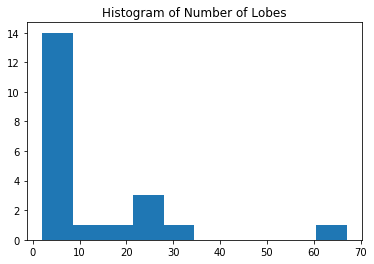

In [37]:
plt.title("Histogram of Number of Lobes")
plt.hist(num_lobes)

(array([13.,  1.,  0.,  0.,  0.,  1.,  3.,  1.,  1.,  1.]),
 array([  0.        ,  18.732325  ,  37.46465001,  56.19697501,
         74.92930001,  93.66162501, 112.39395002, 131.12627502,
        149.85860002, 168.59092502, 187.32325003]),
 <a list of 10 Patch objects>)

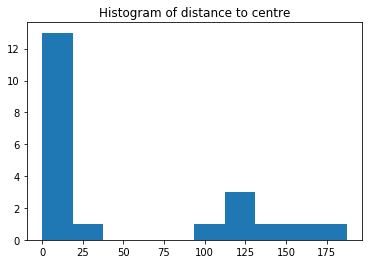

In [38]:
plt.title("Histogram of distance to centre")
plt.hist(dist)

J170115.59+240608.4.fits
Num Lobes


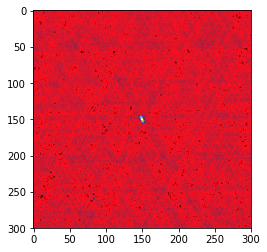

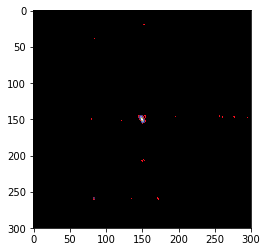

J165448.44+261841.3.fits
Num Lobes


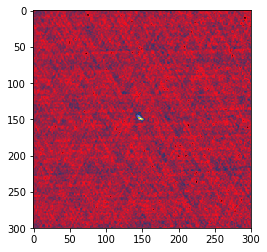

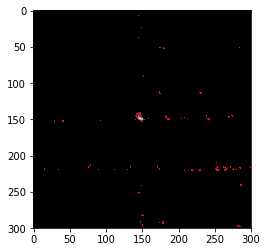

J212005.00075350.1.fits
Num Lobes


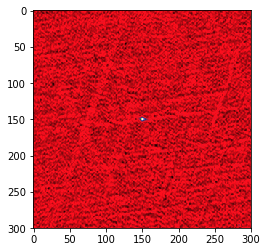

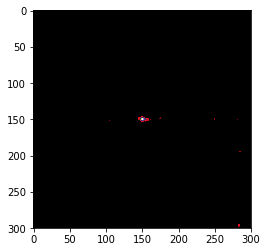

J165425.53+414121.2.fits
Dist


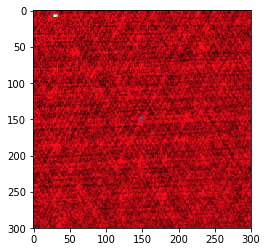

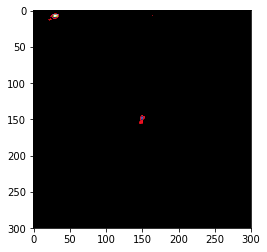

J165304.98+400702.5.fits
Dist


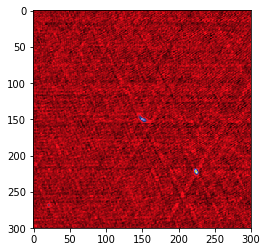

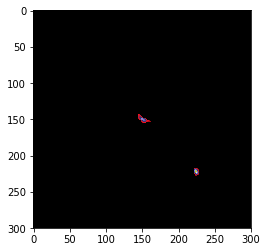

J170543.99+583001.2.fits
Num Lobes


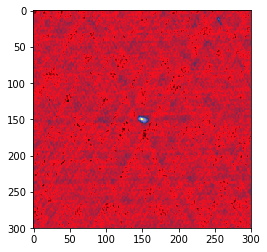

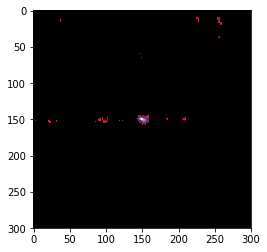

J165744.77+215611.1.fits
Dist


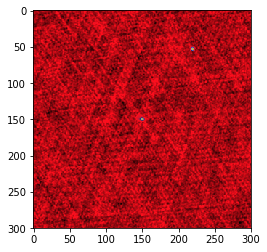

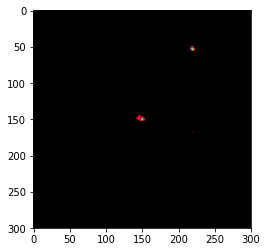

J170011.22+323514.7.fits
Dist


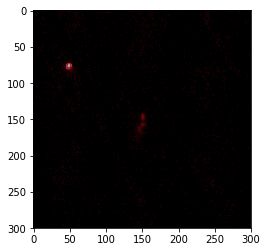

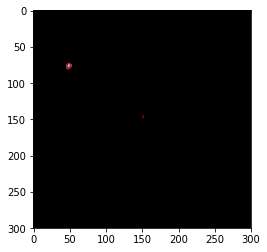

J164548.45+393227.4.fits
Dist


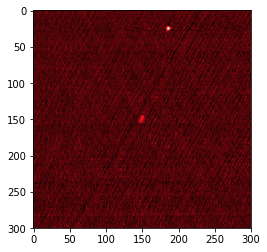

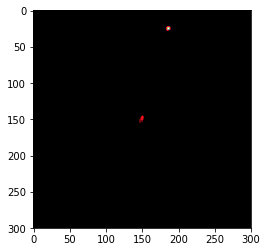

J165500.19+390847.9.fits
Dist


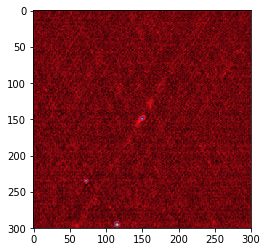

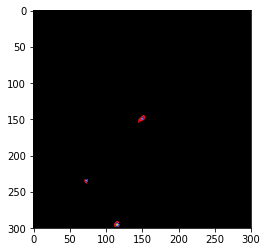

J164053.90+324728.4.fits
Num Lobes


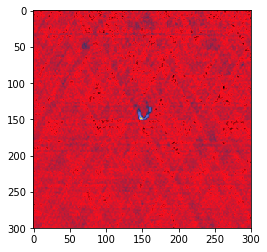

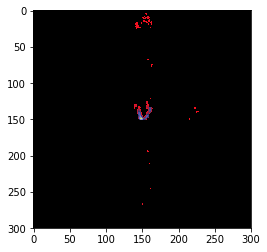

J171137.98+580330.2.fits
Num Lobes


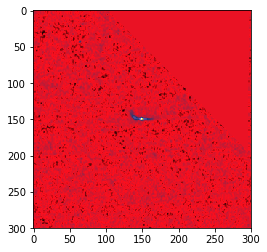

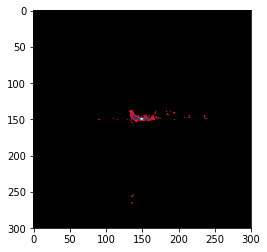

J170602.20+201757.8.fits
Num Lobes


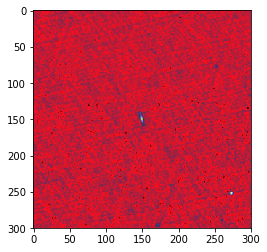

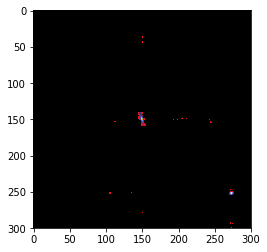

J170602.20+201757.8.fits
Dist


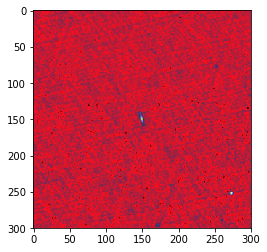

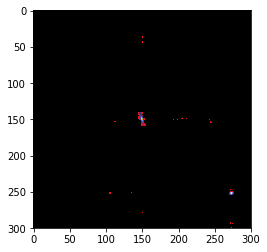

J223143.19082431.7.fits
Num Lobes


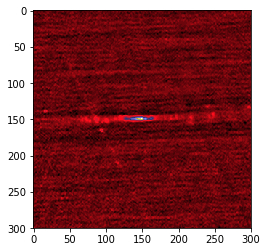

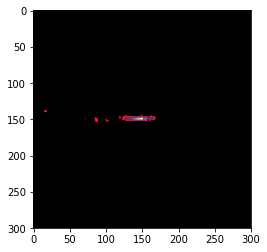

J234702.42010300.9.fits
Num Lobes


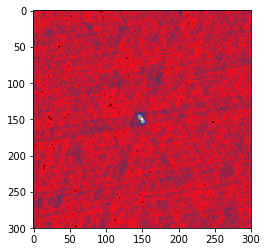

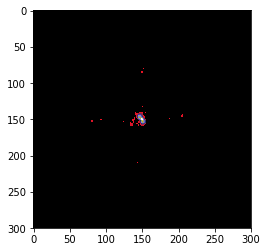

In [52]:
for i in range(len(num_lobes)):
    if num_lobes[i] >5:
        
        print(onlyfits[i])
        print("Num Lobes")
        original = raw_fits[i]
        plt.set_cmap('gist_stern')
        plt.imshow(original)
        plt.show()
        plt.imshow(svd_preproc[i])
        plt.show()
    
    if dist[i] > 50:
        print(onlyfits[i])
        print("Dist")
        original = raw_fits[i]
        plt.set_cmap('gist_stern')
        plt.imshow(original)
        plt.show()
        plt.imshow(svd_preproc[i])
        plt.show()

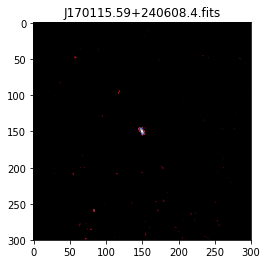

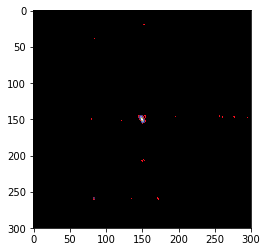

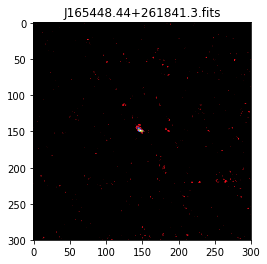

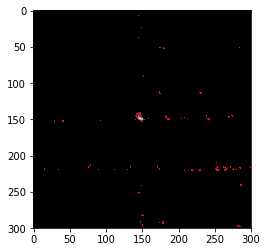

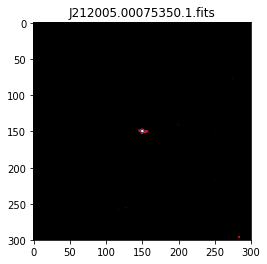

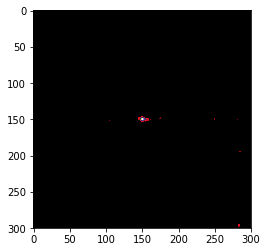

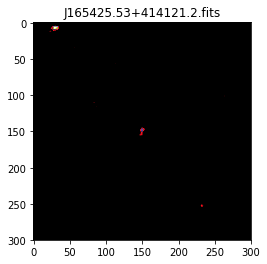

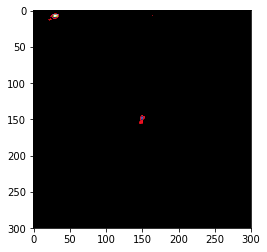

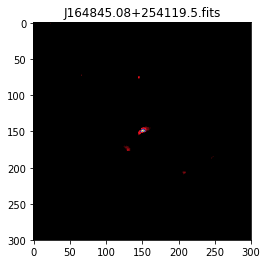

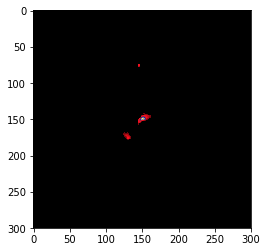

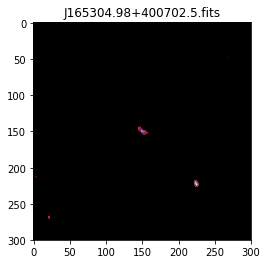

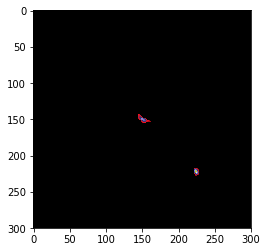

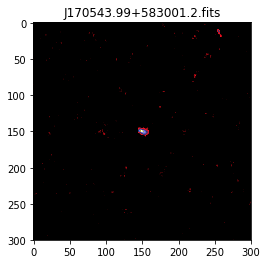

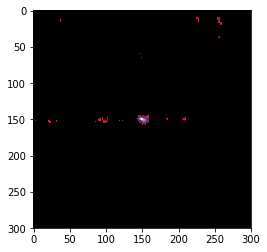

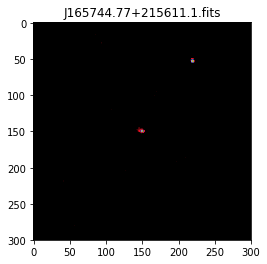

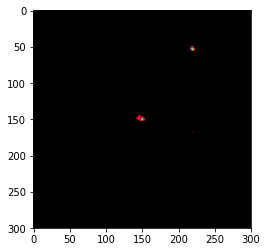

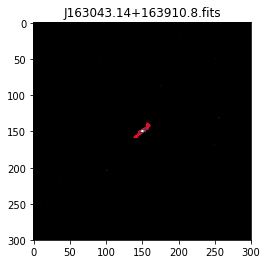

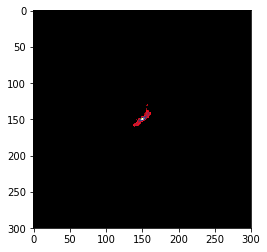

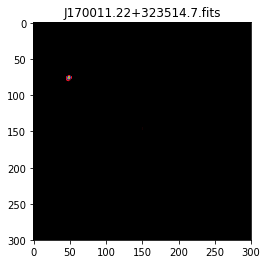

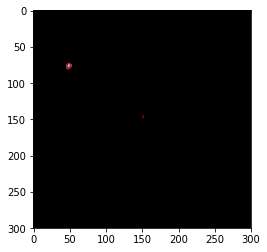

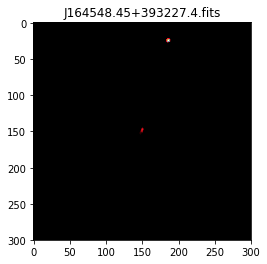

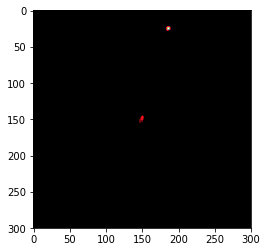

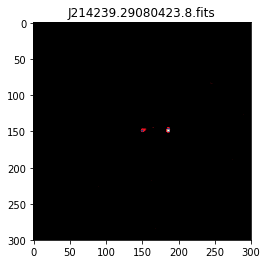

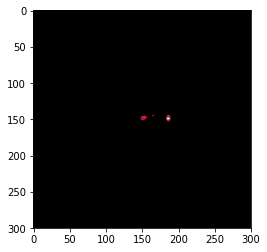

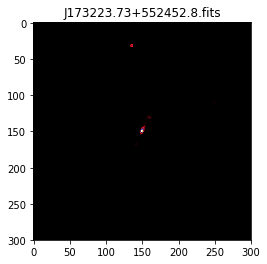

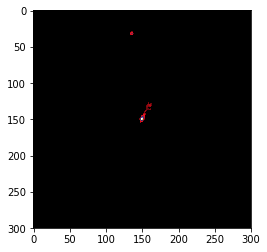

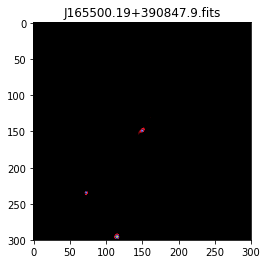

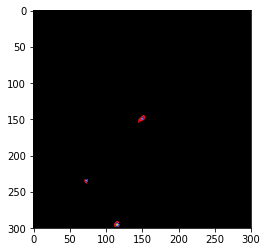

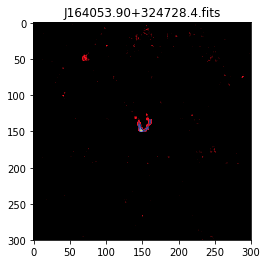

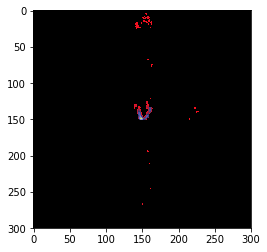

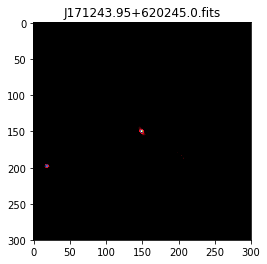

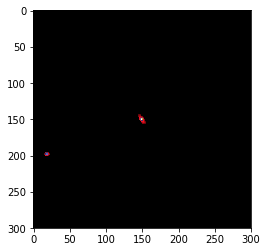

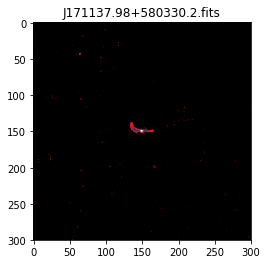

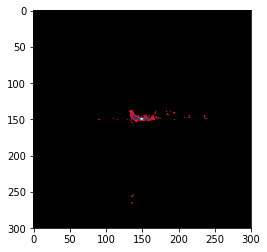

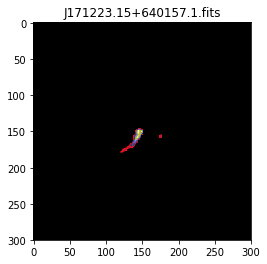

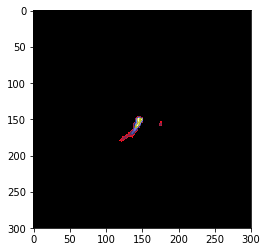

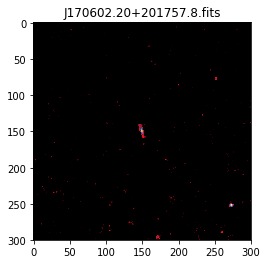

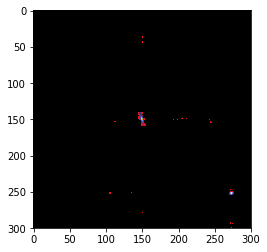

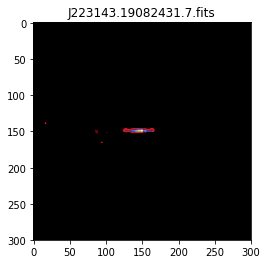

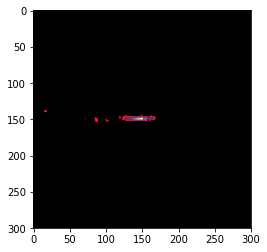

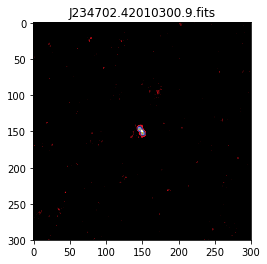

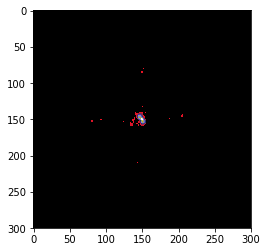

In [50]:
# If you want to visually inspect everything quickly
# for i in range(len(num_lobes)):
#     plt.set_cmap('gist_stern')
#     plt.title(onlyfits[i])
#     plt.imshow(raw_fits[i],vmin=np.mean(raw_fits[i])+np.std(raw_fits[i])*2)
#     plt.show()